In [2]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt

672
Super-Resolution Task
             OT
0      3.162867
1      3.157097
2      3.207673
3      3.036457
4      3.052223
...         ...
25903  3.354253
25904  3.251810
25905  3.553010
25906  3.282873
25907  3.200213

[25908 rows x 1 columns]
train 16984
Super-Resolution Task
             OT
0      3.162867
1      3.157097
2      3.207673
3      3.036457
4      3.052223
...         ...
25903  3.354253
25904  3.251810
25905  3.553010
25906  3.282873
25907  3.200213

[25908 rows x 1 columns]
train 16984
Super-Resolution Task
             OT
0      3.162867
1      3.157097
2      3.207673
3      3.036457
4      3.052223
...         ...
25903  3.354253
25904  3.251810
25905  3.553010
25906  3.282873
25907  3.200213

[25908 rows x 1 columns]
train 16984


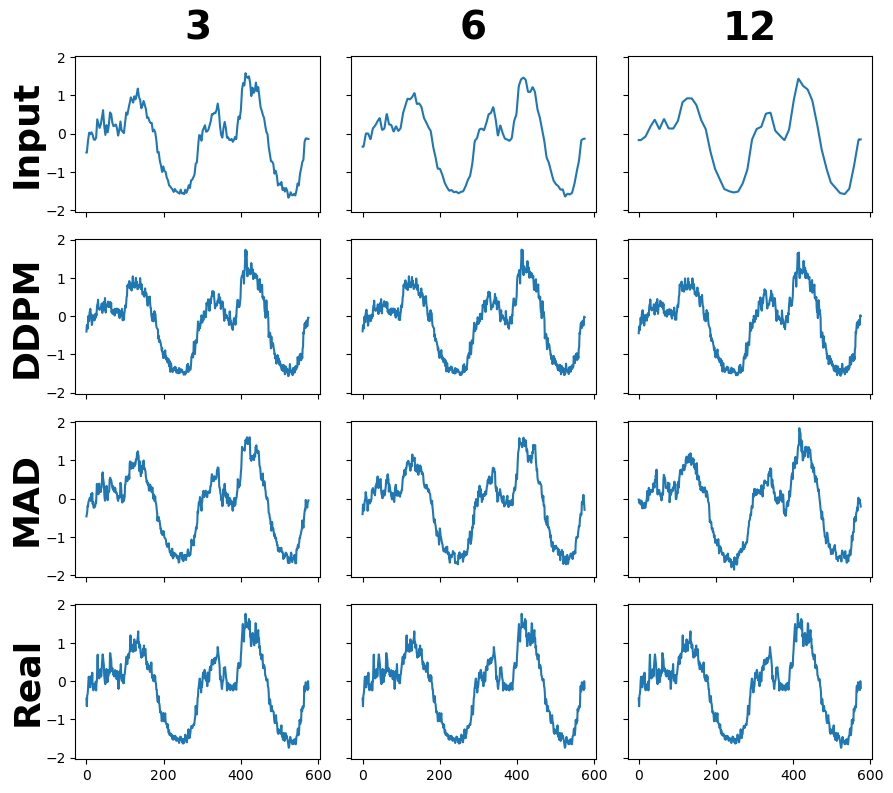

In [ ]:
from src.datamodule.data_factory import data_provider
import torch

root_pth = "/home/user/data/MAD_sr/savings"
# root_pth = "../savings/MAD_sr/savings"
# kernel_size = [2, 4, 8, 16]
kernel_size = [3, 6, 12]
fig, axs = plt.subplots(
    4, len(kernel_size), sharex=True,sharey=True, figsize=[len(kernel_size) * 3, 4 * 2]
)


# cols = ["5%","Bottom 10%","Middle","Top 90%","95%"]
cols = kernel_size
# cols = ["Bottom 10%","Middle","Top 10%"]
# rows = appear_names
rows = ["Input", "DDPM", "MAD", "Real"]

pad = 5

for ax, col in zip(axs[0, :], cols):
    ax.annotate(
        col,
        xy=(0.5, 1.15),
        xytext=(0, -pad),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        size=28,
        ha="center",
        va="baseline",
    )

for ax, row in zip(axs[:, 0], rows):
    if row == "Proposed":
        color = "black"
        alpha = 0.75
        size = 28
    else:
        color = "black"
        alpha = 1
        size = 26
    ax.annotate(
        row,
        xy=(-0.1, 0.5),
        xytext=(-pad, 0),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        rotation=90,
        size=size,
        ha="right",
        va="center",
        color=color,
        alpha=alpha,
    )


dataset = "mfred"
pred_len = 576 if dataset == "mfred" else 720
model_name = "MADTC_NFD_DIT_eps_bs64_condNone_ksNone"
m_name = ["mse", "lsd", "con_err", "lps_st", "lps_lt"]
data_config = yaml.safe_load(open(f"../configs/dataset/{dataset}.yaml", "r"))
data_config["condition"] = "sr"
data_config["pred_len"] = pred_len
data_config["features"] = "TSTR-test"
data_config["batch_size"] = 1024
# MADTC
all_ks_metric_pro = []
all_ks_metric_base = []
max_choose = 700 if dataset == "exchange_rate" else 1024
# choose = 555
choose = np.random.randint(0, max_choose)
print(choose)
for i, ks in enumerate(kernel_size):
    ddpm_data = np.load(
        os.path.join(
            root_pth,
            f"{dataset}_{pred_len}_TSTR-train",
            f"DDPM_bs64_condsr_ks{ks}",
            f"cond_sr_startks_{ks}_fast_False_dtm_True_pred.npy",
        )
    )
    mad_data = np.load(
        os.path.join(
            root_pth,
            f"{dataset}_{pred_len}_TSTR-train",
            model_name,
            f"cond_sr_startks_{ks}_fast_False_dtm_True_pred.npy",
        )
    )

    data_config["kernel_size"] = ks
    _, test_dl = data_provider(data_config, "train")
    batch = next(iter(test_dl))
    linear_interp, y_real = (batch["c"], batch["x"])
    axs[0, i].plot(linear_interp[choose].flatten())
    axs[1, i].plot(ddpm_data[0, choose].flatten())
    axs[2, i].plot(mad_data[0, choose].flatten())
    axs[3, i].plot(y_real[choose].flatten())
fig.tight_layout()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def spider(df, *, id_column, title=None, max_values=None, padding=1.25):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient="list")
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding * max(value) for key, value in data.items()}

    normalized_data = {
        key: np.array(value) / max_values[key] for key, value in data.items()
    }
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    print(tiks)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    for i, model_name in enumerate(ids):
        values = [normalized_data[key][i] for key in data.keys()]
        actual_values = [data[key][i] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        # for _x, _y, t in zip(angles, values, actual_values):
        #     t = f"{t:.2f}" if isinstance(t, float) else str(t)
        #     ax.text(_x, _y, t, size="xx-small")

    # ax.fill(angles, np.ones(num_vars + 1), alpha=0.05)
    # ax.set_yscale('log')
    ax.set_yticklabels([])
    ax.set_thetagrids(np.degrees(np.linspace(0, 2*np.pi, num_vars+1, endpoint=False)), tiks)
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks)
    ax.set_theta_zero_location("N")
    ax.legend(bbox_to_anchor=(1.25, 1.2), ncols=4)
    if title is not None:
        ax.set_title(title)
    # fig.savefig("test.png")

df = pd.read_csv('../assets/ablation.csv', index_col=0)
datasets = df['dataset'].unique()
all_values = []
all_name = []
for name, subdf in df.groupby('model'):
    values = subdf['cfid'].values.flatten().reshape(-1,1)
    all_values.append(values)
    all_name.append(name)
print(all_name)
df = pd.DataFrame(np.concatenate(all_values, axis=1), columns=['DDPM', 'DDPM+MA', 'DDPM+MA+stdsched', 'DDPM+norm', 'DDPM+norm+MA', 'DDPM+norm+MA+stdsched'], index=datasets)
# df=df.reset_index()
# df = df[['DDPM','DDPM+norm']]
df = df[['DDPM+norm+MA+stdsched','DDPM+norm+MA']]
# df = df[['DDPM+norm+MA+stdsched','DDPM+norm','DDPM+MA+stdsched', "DDPM"]]
df = df.T
df = df[['wind','solar','mfred']]
print(df.to_latex(float_format='%.4f'))
# display(df[['wind','solar','mfred']])

# df = df/df.min()
# df = df.sum(axis=1)
# display(df)
# print(df.rank().mean(axis=1))
# df = df.reset_index()
# df = df.drop(columns=['weather','ettm2'])
# df = df.drop(index =[0,1])
# df = df.rename(columns={'exchange_rate':'exchange'})
# display(df)
# spider(df, id_column='index')

['DDPM', 'DDPM_MA', 'DDPM_MA_stdsched', 'DDPM_norm', 'DDPM_norm_MA', 'DDPM_norm_MA_stdsched']
\begin{tabular}{lrrr}
\toprule
{} &    wind &  solar &  mfred \\
\midrule
DDPM+norm+MA+stdsched & 16.9026 & 8.0297 & 2.6742 \\
DDPM+norm+MA          & 17.1669 & 7.5422 & 4.2962 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_201048/1311290228.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='%.4f'))


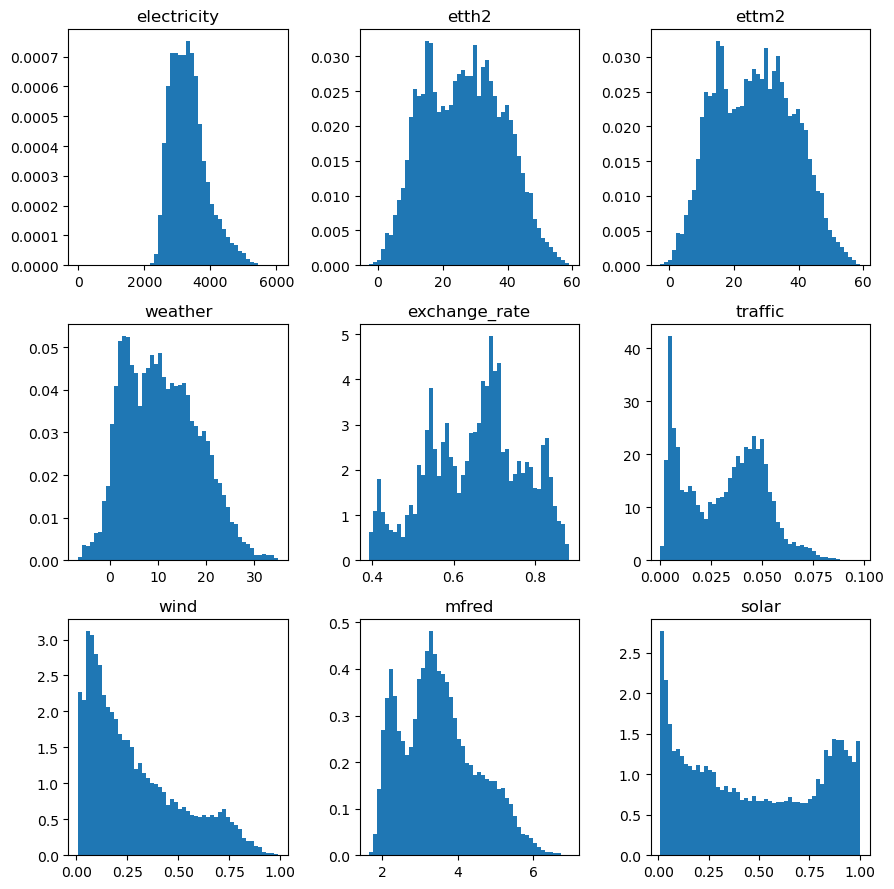

In [64]:


datasets = ['electricity', 'etth2','ettm2','weather', 'exchange_rate', 'traffic', 'wind', 'mfred', 'solar']
fig, axs = plt.subplots(len(datasets)//3, 3, figsize=[3*3, len(datasets)//3*3])
axs = axs.flatten()
for i, d in enumerate(datasets):
    data_config = yaml.safe_load(open(f"../configs/dataset/{d}.yaml", "r"))
    df = pd.read_csv(os.path.join(data_config['root_path'], data_config['data_path']), index_col=0, parse_dates=True)[[data_config['target']]]
    if d in ['wind', 'solar']:
        df = df[df>0.01]
    if d in ['traffic']:
        df = df[df<0.1]
    axs[i].hist(df.values.flatten(), bins=50, density=True)
    axs[i].set_title(d)

    # break
fig.tight_layout()

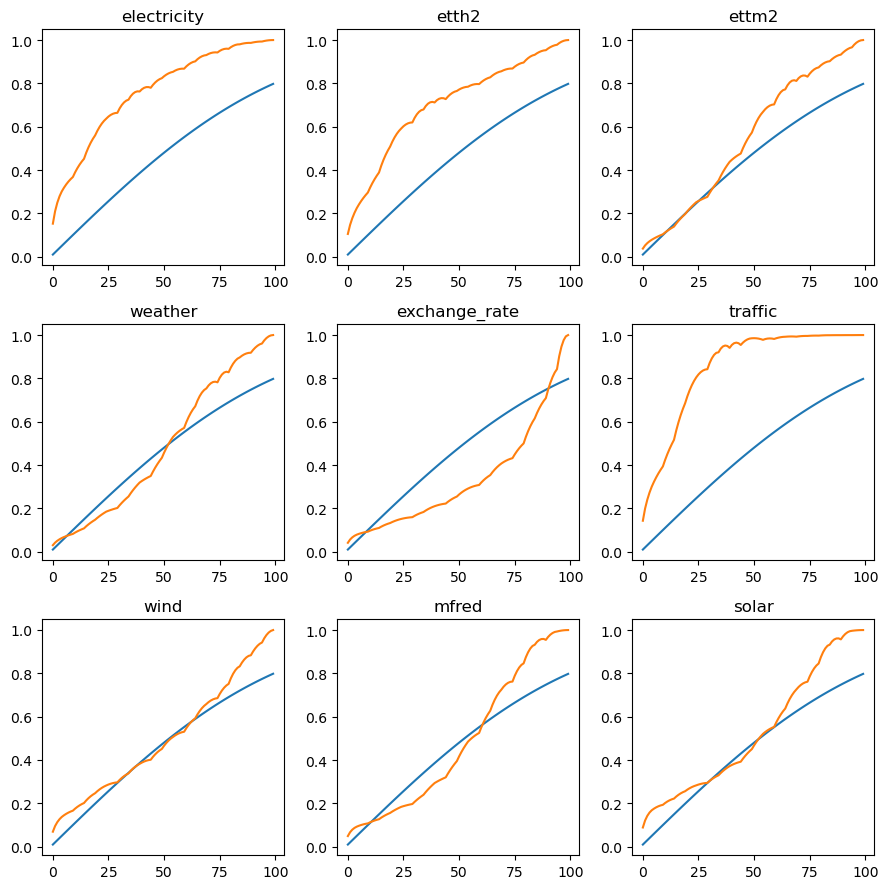

In [82]:
import torch

datasets = ['electricity', 'etth2','ettm2','weather', 'exchange_rate', 'traffic', 'wind', 'mfred', 'solar']
fig, axs = plt.subplots(len(datasets)//3, 3, figsize=[3*3, len(datasets)//3*3])
axs = axs.flatten()
for i, d in enumerate(datasets):
    # data_config = yaml.safe_load(open(f"../configs/dataset/{d}.yaml", "r"))
    # df = pd.read_csv(os.path.join(data_config['root_path'], data_config['data_path']), index_col=0, parse_dates=True)[[data_config['target']]]
    # if d in ['wind', 'solar']:
        # df = df[df>0.01]
    # if d in ['traffic']:
        # df = df[df<0.1]
    lin_sched = torch.load(f'/home/user/data/MAD_ablation/savings/{d}_576_S/ma_lin_sched_100.pt')['betas'].flatten()
    std_sched = torch.load(f'/home/user/data/MAD_ablation/savings/{d}_576_S/std_sched_100.pt')['betas'].flatten()
    axs[i].plot(lin_sched, label='linear')
    axs[i].plot(std_sched, label='std')
    axs[i].set_title(d)

    # break
fig.tight_layout()

In [2]:
import pandas  as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/home/user/workspaces/FrequencyDiffusion/assets/sr_mfred_cfid_new.csv')
print(df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrl}
\toprule
{} &    mse &     lsd &  con\_err &   cfid &  ks &                              model\_name \\
\midrule
0  & 0.0109 & 14.8904 &   0.0032 & 0.1047 &   3 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
1  & 0.0184 & 15.5683 &   0.0037 & 0.1235 &   6 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
2  & 0.0282 & 15.8024 &   0.0047 & 0.4358 &  12 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
3  & 0.0412 & 15.3185 &   0.0291 & 3.1028 &   3 &                   DDPM\_bs64\_condsr\_ks12 \\
4  & 0.0420 & 15.3295 &   0.0214 & 3.0740 &   6 &                   DDPM\_bs64\_condsr\_ks12 \\
5  & 0.0453 & 15.3669 &   0.0157 & 3.4044 &  12 &                   DDPM\_bs64\_condsr\_ks12 \\
6  & 0.0406 & 15.2604 &   0.0286 & 1.3449 &   3 &              DDPM\_T200\_bs64\_condsr\_ks12 \\
7  & 0.0436 & 15.2919 &   0.0230 & 1.7373 &   6 &              DDPM\_T200\_bs64\_condsr\_ks12 \\
8  & 0.0453 & 15.3100 &   0.0161 & 1.9947 &  12 &              DDPM\_T200\_bs64\_co

/tmp/ipykernel_225543/1308893376.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.4f"))


In [ ]:
df = pd.read_csv('/home/user/workspaces/FrequencyDiffusion/assets/sr_wind_cfid_new.csv')
print(df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrl}
\toprule
{} &    mse &     lsd &  con\_err &   cfid &  ks &                              model\_name \\
\midrule
0 & 0.0133 & 13.9932 &   0.0067 & 0.2863 &   3 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
1 & 0.0271 & 14.9327 &   0.0098 & 1.0241 &   6 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
2 & 0.0525 & 15.5355 &   0.0136 & 3.0567 &  12 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
3 & 0.0446 & 14.6555 &   0.0382 & 7.4843 &   3 &                               Cond DDPM \\
4 & 0.0487 & 14.7485 &   0.0343 & 7.9524 &   6 &                               Cond DDPM \\
5 & 0.0606 & 14.8796 &   0.0318 & 9.2504 &  12 &                               Cond DDPM \\
6 & 0.0028 & 14.6379 &   0.0004 & 0.2942 &   3 &                          Linear Interp. \\
7 & 0.0077 & 18.0996 &   0.0013 & 2.2570 &   6 &                          Linear Interp. \\
8 & 0.0186 & 19.6417 &   0.0026 & 9.8934 &  12 &                          Linear Interp. \\
\bottomrule
\end

/tmp/ipykernel_138458/2675425118.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.4f"))


In [20]:
df = pd.read_csv('/home/user/workspaces/FrequencyDiffusion/assets/sr_mfred_cfid_new.csv')
print(df.to_latex(float_format="%.4f"))


\begin{tabular}{lrrrrrl}
\toprule
{} &    mse &     lsd &  con\_err &   cfid &  ks &                              model\_name \\
\midrule
0 & 0.0109 & 14.8904 &   0.0032 & 0.1047 &   3 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
1 & 0.0184 & 15.5683 &   0.0037 & 0.1235 &   6 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
2 & 0.0282 & 15.8024 &   0.0047 & 0.4358 &  12 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
3 & 0.0412 & 15.3185 &   0.0291 & 3.1028 &   3 &                               Cond DDPM \\
4 & 0.0420 & 15.3295 &   0.0214 & 3.0740 &   6 &                               Cond DDPM \\
5 & 0.0453 & 15.3669 &   0.0157 & 3.4044 &  12 &                               Cond DDPM \\
6 & 0.0056 & 27.2184 &   0.0005 & 0.8873 &   3 &                          Linear Interp. \\
7 & 0.0101 & 36.6368 &   0.0007 & 1.6654 &   6 &                          Linear Interp. \\
8 & 0.0156 & 37.1328 &   0.0013 & 3.4139 &  12 &                          Linear Interp. \\
\bottomrule
\end

/tmp/ipykernel_163401/186887546.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.4f"))


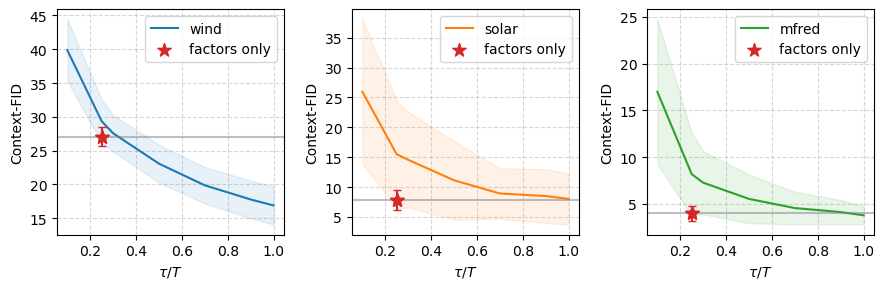

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ratio_diff_step = [0.1, 0.25, 0.3, 0.5, 0.7, 0.9, 1.0]
datasets = ["wind", "solar", "mfred"]
# datasets = ["exchange_rate","wind", "solar", "mfred"]

all_avg_m, all_std_m = [], []
for i, rds in enumerate(ratio_diff_step):
    fast_avg_m, fast_std_m = [], []
    ds_avg_m, ds_std_m = [], []
    for ds in datasets:
        m = np.load(
            f"/home/user/data/MAD_ablation/savings/{ds}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_metric.npy"
        )
        # m = m.reshape(10, 5)
        # m = m.mean(axis=0)
        fast_m = np.load(
            f"/home/user/data/MAD_ablation/savings/{ds}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_True_rds_1.0_metric.npy"
        )
        # fast_m = fast_m.reshape(10, 5)
        # fast_m = fast_m.mean(axis=0)
        avg_m = m.mean()
        std_m = m.std()
        ds_avg_m.append(avg_m)
        ds_std_m.append(std_m)
        fast_avg_m.append(fast_m.mean())
        fast_std_m.append(fast_m.std())
    all_avg_m.append(ds_avg_m)
    all_std_m.append(ds_std_m)

all_avg_m = np.array(all_avg_m)
all_std_m = np.array(all_std_m)

fig, axs = plt.subplots(1, 3, figsize=[3 * 3, 1 * 3])
axs = axs.flatten()
for i in range(len(datasets)):
    axs[i].plot(ratio_diff_step, all_avg_m[:, i], c=f"C{i}", label=datasets[i])
    axs[i].fill_between(
        ratio_diff_step,
        (all_avg_m - all_std_m)[:, i],
        (all_avg_m + all_std_m)[:, i],
        alpha=0.1,
        color=f"C{i}",
    )
    # axs[i].set_xticks(ratio_diff_step)
    axs[i].set_axisbelow(True)
    axs[i].grid(alpha=0.5, linestyle="dashed")
    # axs[i].set_xscale('synlog')

    # vline = np.array([fast_avg_m[i] for _ in range(len(ratio_diff_step))])
    # idx = np.argwhere(np.diff(vline - np.sign(all_avg_m[:, i]))).flatten()
    # axs[i].plot(all_avg_m[:, i][idx], vline[idx], 'ro')
    # axs[i].axvline([0.25], c='grey', alpha=0.5)
    axs[i].axhline([fast_avg_m[i]], c='grey', alpha=0.5)
    axs[i].scatter([0.25], fast_avg_m[i], marker="*",color="C3", s=100,label='factors only')
    axs[i].errorbar([0.25], fast_avg_m[i], yerr=fast_std_m[i], marker="*", color="C3", capsize=3, ms=10)
    
    axs[i].set_ylabel(u'Context-FID')
    axs[i].set_xlabel(u'$\\tau/T$')
    axs[i].legend()
    # axs[i].scatter([0.25], fast_avg_m[i], marker='s', color='red')
    # choose = np.random.randint(1024)
    # plot_ratio = [0.1, 0.25, 1.0]
    # for j in range(3):
    #     plot_x = np.load(
    #         f"/home/user/data/MAD_ablation/savings/{datasets[i]}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{plot_ratio[j]}_syn.npy"
    #     )
    #     axs[i, j+1].plot(plot_x[choose, :].flatten())

fig.tight_layout()

# plt.plot()
# plt.xscale('log')

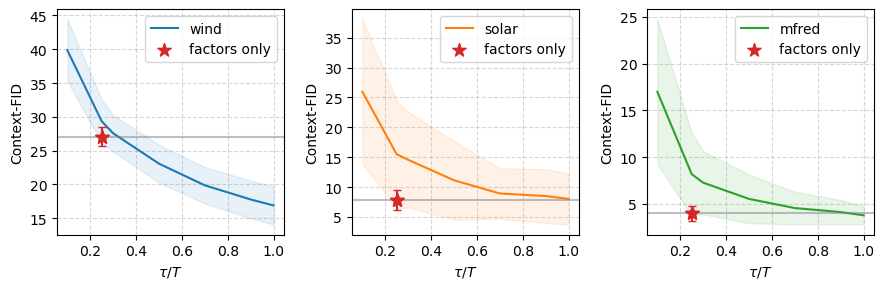

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ratio_diff_step = [0.1, 0.25, 0.3, 0.5, 0.7, 0.9, 1.0]
datasets = ["wind", "solar", "mfred"]
# datasets = ["exchange_rate","wind", "solar", "mfred"]

all_avg_m, all_std_m = [], []
for i, rds in enumerate(ratio_diff_step):
    fast_avg_m, fast_std_m = [], []
    ds_avg_m, ds_std_m = [], []
    for ds in datasets:
        m = np.load(
            f"/home/user/data/MAD_ablation/savings/{ds}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_metric.npy"
        )
        # m = m.reshape(10, 5)
        # m = m.mean(axis=0)
        fast_m = np.load(
            f"/home/user/data/MAD_ablation/savings/{ds}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_True_rds_1.0_metric.npy"
        )
        # fast_m = fast_m.reshape(10, 5)
        # fast_m = fast_m.mean(axis=0)
        avg_m = m.mean()
        std_m = m.std()
        ds_avg_m.append(avg_m)
        ds_std_m.append(std_m)
        fast_avg_m.append(fast_m.mean())
        fast_std_m.append(fast_m.std())
    all_avg_m.append(ds_avg_m)
    all_std_m.append(ds_std_m)

all_avg_m = np.array(all_avg_m)
all_std_m = np.array(all_std_m)

fig, axs = plt.subplots(1, 3, figsize=[3 * 3, 1 * 3])
axs = axs.flatten()
for i in range(len(datasets)):
    axs[i].plot(ratio_diff_step, all_avg_m[:, i], c=f"C{i}", label=datasets[i])
    axs[i].fill_between(
        ratio_diff_step,
        (all_avg_m - all_std_m)[:, i],
        (all_avg_m + all_std_m)[:, i],
        alpha=0.1,
        color=f"C{i}",
    )
    # axs[i].set_xticks(ratio_diff_step)
    axs[i].set_axisbelow(True)
    axs[i].grid(alpha=0.5, linestyle="dashed")
    # axs[i].set_xscale('synlog')

    # vline = np.array([fast_avg_m[i] for _ in range(len(ratio_diff_step))])
    # idx = np.argwhere(np.diff(vline - np.sign(all_avg_m[:, i]))).flatten()
    # axs[i].plot(all_avg_m[:, i][idx], vline[idx], 'ro')
    # axs[i].axvline([0.25], c='grey', alpha=0.5)
    axs[i].axhline([fast_avg_m[i]], c='grey', alpha=0.5)
    axs[i].scatter([0.25], fast_avg_m[i], marker="*",color="C3", s=100,label='factors only')
    axs[i].errorbar([0.25], fast_avg_m[i], yerr=fast_std_m[i], marker="*", color="C3", capsize=3, ms=10)
    
    axs[i].set_ylabel(u'Context-FID')
    axs[i].set_xlabel(u'$\\tau/T$')
    axs[i].legend()
    # axs[i].scatter([0.25], fast_avg_m[i], marker='s', color='red')
    # choose = np.random.randint(1024)
    # plot_ratio = [0.1, 0.25, 1.0]
    # for j in range(3):
    #     plot_x = np.load(
    #         f"/home/user/data/MAD_ablation/savings/{datasets[i]}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{plot_ratio[j]}_syn.npy"
    #     )
    #     axs[i, j+1].plot(plot_x[choose, :].flatten())

fig.tight_layout()

# plt.plot()
# plt.xscale('log')

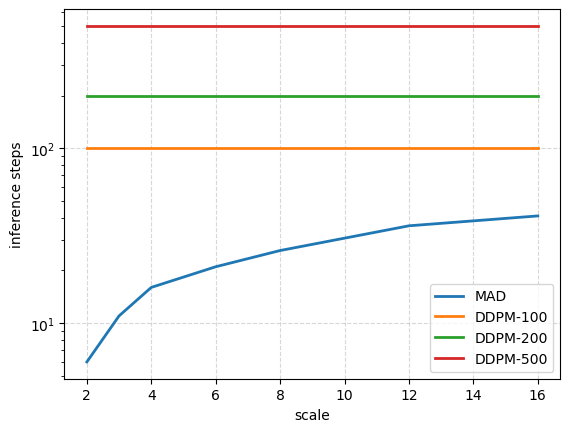

In [ ]:
scale = [2, 3, 4, 6, 8, 12, 16]
sample_steps = [6, 11, 16, 21, 26, 36, 41]
fig, axs = plt.subplots()
axs.plot(scale, sample_steps, label="MAD", lw=2)
axs.plot(scale, [100 for _ in range(len(scale))], label="DDPM-100", lw=2)
axs.plot(scale, [200 for _ in range(len(scale))], label="DDPM-200", lw=2)
axs.plot(scale, [500 for _ in range(len(scale))], label="DDPM-500", lw=2)
# axs.plot(scale, [1000 for _ in range(len(scale))], label='DDPM-1000')
axs.legend()
axs.set_ylabel("inference steps")
axs.set_xlabel("scale")
axs.set_axisbelow(True)
axs.grid(alpha=0.5, linestyle="dashed")
axs.set_yscale("log")